 # Luonnollisen kielen käsittelyn (NLP) demo

Demo mukailee esimerkki-tutorialia: https://www.tensorflow.org/hub/tutorials/tf2_text_classification

Määritellään tarvittavat Python-kieliset paketit:

In [1]:
import os
import pickle
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow import keras

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2021-09-27 16:15:27.507192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-27 16:15:27.507308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


2021-09-27 16:15:31.897759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-27 16:15:31.897856: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-27 16:15:31.898551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0ac8024c52f1): /proc/driver/nvidia/version does not exist


train_examples[:10]

In [2]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2021-09-27 16:15:31.918852: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.
2021-09-27 16:15:31.996945: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [3]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [4]:
train_examples[0]

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [5]:
train_labels[0]

0

In [6]:
train_examples[5]

b"This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl, its causes and its symptoms. The girl is played by one of the most brilliant young actresses working in cinema today, Alison Lohman, who was later so spectacular in 'Where the Truth Lies'. I would recommend that this film be shown in all schools, as you will never see a better on this subject. Alison Lohman is absolutely outstanding, and one marvels at her ability to convey the anguish of a girl suffering from this compulsive disorder. If barometers tell us the air pressure, Alison Lohman tells us the emotional pressure with the same degree of accuracy. Her emotional range is so precise, each scene could be measured microscopically for its gradations of trauma, on a scale of rising hysteria and desperation which reaches unbearable intensity. Mare Winningham is the perfect choice to play her m

In [7]:
train_labels[5]

1

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
# hub_layer(train_examples[:3])

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

Mallin opetusta (kesto olisi n. 12 min)

In [27]:
model_dir = '../work/nlp_model'

if os.path.exists(model_dir):
    model = keras.models.load_model(model_dir)

    with open(os.path.join(model_dir, 'hist.pkl'), 'rb') as handle:
        hist = pickle.load(handle)
else:
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=40,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    model.save(model_dir)
                                
    with open(os.path.join(model_dir, 'hist.pkl'), 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    hist = history.history

In [22]:
results = model.evaluate(test_data, test_labels)

782/782 [==============================] - 73s 93ms/step - loss: 0.6243 - accuracy: 0.8476


In [28]:
history_dict = hist
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

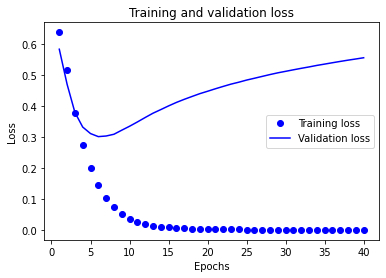

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

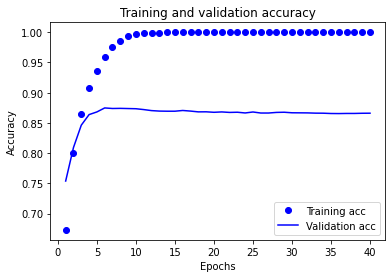

In [30]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()